In [195]:
import os
import gc
import time
import json
import random
import numpy as np
import pandas as pd
import lightgbm as lgb
from tqdm import tqdm

from joblib import Parallel, delayed

import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

In [196]:
with open('./env/settings.json')as f:
  path_file = json.load(f)

TRAIN_PROCESSED_DATA_PATH = path_file["TRAIN_PROCESSED_DATA_PATH"]
TEST_PROCESSED_DATA_PATH = path_file["TEST_PROCESSED_DATA_PATH"]

PROCESSED_DATA_DIR = path_file["PROCESSED_DATA_DIR"]
SUBMISSION_DIR = path_file["SUBMISSION_DIR"]

OUTPUT_DIR = path_file["OUTPUT_DIR"]

In [197]:
TARGET_COL = "取引価格（総額）_log"
ID_COL = "ID"
RANDOM_STATE = 42

In [198]:
def set_seed(seed=42):
  np.random.seed(seed)
  random.seed(seed)
  os.environ["PYTHONHASHSEED"]=str(seed)

In [199]:
train_df=pd.read_csv(TRAIN_PROCESSED_DATA_PATH)
test_df=pd.read_csv(TEST_PROCESSED_DATA_PATH)

In [200]:
train_df["isTest"] = 0
test_df["isTest"] = 1
all_df = pd.concat([train_df,test_df])

In [201]:
from sklearn.preprocessing import LabelEncoder

qualitative = [f for f in train_df.columns if train_df.dtypes[f] == 'object']

for col in qualitative:
  le = LabelEncoder()
  le.fit(all_df[col])
  all_df[col] = le.transform(all_df[col])

In [202]:
all_df = all_df.fillna(all_df.mode().iloc[0])

In [203]:
from sklearn.preprocessing import StandardScaler 
ss_col = list( set(all_df.columns.to_list()) - set(["ID","取引価格（総額）_log","isTest"]))

ss = StandardScaler()
ss.fit(all_df[ss_col])
all_df[ss_col] = ss.transform(all_df[ss_col])

In [204]:

train_df = all_df[all_df["isTest"] == 0].drop("isTest",axis=1)
test_df = all_df[all_df["isTest"] == 1].drop(["isTest","取引価格（総額）_log"],axis=1)

In [205]:
train_df.head(3)

,ID,市区町村コード,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,建築年,建物の構造,用途,今後の利用目的,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引価格（総額）_log
0,1060685,-1.814578,-1.389598,0.217832,-0.498332,-0.647407,-0.291924,0.527291,0.962571,-0.042190,1.264283,-0.295188,0.860422,-0.173433,-0.713159,-0.669949,-0.960576,0.289486,7.079181
1,1005580,-1.815308,-1.389598,0.199605,-0.891804,-1.503594,-0.541793,-1.734590,-1.240865,-1.171005,1.264283,3.334662,-0.955253,1.400902,1.225464,0.011258,1.231692,0.289486,6.755875
2,1001363,-1.815308,-1.389598,0.199605,-1.034571,1.247403,-0.042056,0.527291,0.301541,-0.389517,1.264283,-0.295188,0.860422,1.400902,1.225464,0.011258,-0.835304,0.289486,7.204120


In [206]:
from sklearn.model_selection import train_test_split

del_col = [TARGET_COL,"ID"]
y_train = train_df[TARGET_COL]

X_train,X_test,y_train,y_test = train_test_split(train_df.drop(del_col,axis=1),y_train,train_size=0.75,shuffle=True,random_state=RANDOM_STATE)

In [207]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [208]:
X_train.columns

Index(['市区町村コード', '都道府県名', '市区町村名', '地区名', '最寄駅：名称', '最寄駅：距離（分）', '間取り',
       '面積（㎡）', '建築年', '建物の構造', '用途', '今後の利用目的', '都市計画', '建ぺい率（％）', '容積率（％）',
       '取引時点', '改装'],
      dtype='object')

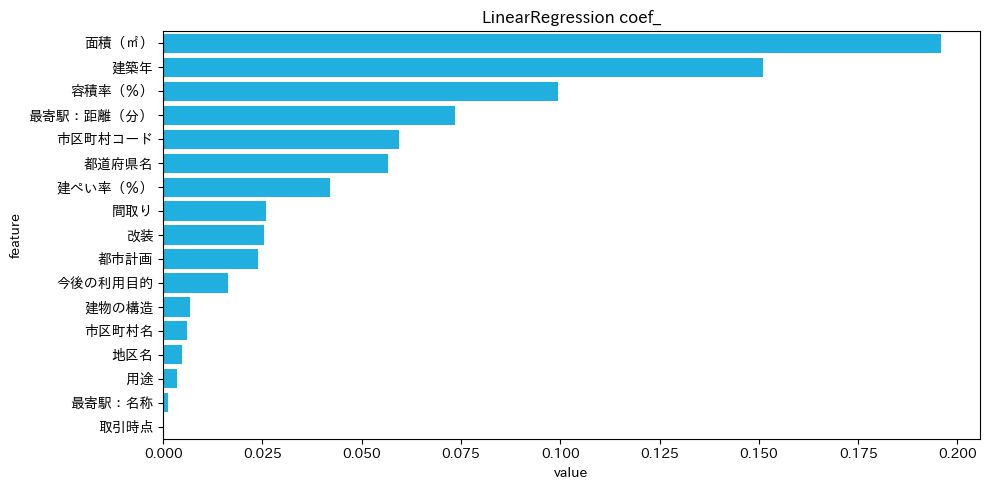

In [209]:
feature_imp = pd.DataFrame(sorted(zip(np.abs(lr.coef_),X_train.columns)),columns=['value','feature'])
plt.figure(figsize=(10,5))
sns.barplot(data=feature_imp.sort_values(by='value',ascending=False),x="value",y="feature",color="deepskyblue")
plt.title("LinearRegression coef_")
plt.tight_layout()
plt.show()

In [210]:
from sklearn.metrics import mean_absolute_error
y_pred = lr.predict(X_test)
mean_absolute_error(y_test,y_pred)

0.17553636223427785

In [211]:
test_df[TARGET_COL] = lr.predict(test_df.drop("ID",axis=1))

submission = pd.read_csv(SUBMISSION_DIR)
submission["取引価格（総額）_log"] = test_df[TARGET_COL]
submission = pd.merge(submission["ID"], test_df[["ID","取引価格（総額）_log"]], on="ID")

In [212]:
submission

,ID,取引価格（総額）_log
0,1000000,7.188772
1,1000056,7.704291
2,1000108,6.869441
3,1000109,7.204846
4,1000110,6.769197
...,...,...
19461,47003828,7.578019
19462,47003829,7.286010
19463,47003880,7.040516
19464,47006648,7.332219


In [ ]:
exp_name = "liniearregression_baseline"

import pytz
import datetime

now = datetime.datetime.now(pytz.timezone('Asia/Tokyo')).strftime('%Y-%m--%d-%H-%M-%S')
if not os.path.exists(OUTPUT_DIR):
  os.mkdir(OUTPUT_DIR)

submission.to_csv(f"{OUTPUT_DIR}submission_{exp_name}_{now}.csv",index=False)